In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as scp
import scipy.stats

import torch
from torch.nn import functional as F
from torch import nn, Tensor

from torch.optim import Adam

from typing import Optional, Tuple

import matplotlib.pyplot as plt
import seaborn as sns

from grassmann_distribution.GrassmannDistribution import GrassmannBinary
from grassmann_distribution.utils import check_valid_sigma
from grassmann_distribution.conditional_grassmann import hidden_fc_net, GrassmannConditional

import pickle


In [6]:
"""
loading example data from 3 dimensional dichotomized gaussian distribution
100k samples were split up into 10k test and the rest training
per parameterset (gt_mean and gt_cov, with corresponding gauss_mean ang gauss_corr) there is one three dim. sample (1,3)
"""

with open("../data/dg_data_preprocessed.pkl", "rb") as file:
    data_dict = pickle.load(file )
    
gauss_mean_train=data_dict['gauss_mean_train']
gauss_mean_test=data_dict['gauss_mean_test']
gauss_corr_train=data_dict['gauss_corr_train']
gauss_corr_test=data_dict['gauss_corr_test']
samples_train=data_dict['samples_train']
samples_test=data_dict['samples_test']
gt_mean_train=data_dict['gt_mean_train']
gt_mean_test=data_dict['gt_mean_test']
gt_cov_train=data_dict['gt_cov_train']
gt_cov_test=data_dict['gt_cov_test']


### Conditional Grassmann

In [7]:
# prepare data

# a 6-dim "context" vector will be used as input to the network
# this tensor includes the gauss_mean and trilled gauss_corr (only upper triangle)

def prepare_data(gauss_corr, gauss_mean):
    """
    prepare data
    """
    dim = gauss_corr.shape[1]
    n = gauss_corr.shape[0]
    data_in = torch.zeros(n, int(dim*(dim-1)/2) + dim)

    data_in[:,:dim] = torch.tensor(gauss_mean)

    tril_inds = np.tril_indices(dim, -1)
    for i in range(n):
        data_in[i,dim:] = torch.tensor(gauss_corr[i][tril_inds])

    return data_in

data_in_train = prepare_data(gauss_corr_train,gauss_mean_train)
data_in_test = prepare_data(gauss_corr_test,gauss_mean_test)

print(data_in_train.shape)

torch.Size([990000, 6])


In [8]:
"""
set up network
"""
h = hidden_fc_net(input_dim=6,
                  output_dim=16,
                  num_fc_layers=3, # numer of layers
                 num_hiddens=64) # hidden dimension (should be large enough...)

model = GrassmannConditional(features =3, # dim
                                hidden_features=16, # output dim of hidden net
                                hidden_net=h,
                                num_components=2)

In [9]:
"""
Training
"""
steps = 500
#batch_size = 40_000
verbose = True
clip_gradient = False

optimizer = Adam(model.parameters(), lr=0.001)

loss_stored = []
id_list = np.arange(samples_train.shape[0])



running_loss = 0.0
r = 0
print('Started training...')
for batch_size in [10_000,20_000]:
    print("starting round with batchsize:",batch_size)
    for step in range(steps): 

        # get the inputs; data is a list of [inputs, labels]
        ids = np.random.choice(id_list, size=batch_size, replace=False)
        _x = samples_train[ids]
        _context = data_in_train[ids]


        if step==0 and verbose:
            print(f"data shape of one batch: {_x.shape}")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        logprob = torch.log(model.prob(_x,_context))

        loss = -logprob.mean()
        #loss.requires_grad = True

        loss.backward()

        if clip_gradient:
            # clip gradient of params
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1, error_if_nonfinite=True)

        optimizer.step()

        # print statistics
        running_loss += loss.item()
        loss_stored.append(loss.item())

        if verbose:
            if step % 100 ==1:
                print(f'''step [{step}] loss: {np.mean(loss_stored[(steps*r+step-99):steps*r+step]):.3f} ''')
    r+=1
print('Finished Training.')

Started training...
starting round with batchsize: 10000
data shape of one batch: torch.Size([10000, 3])
step [1] loss: 2.170 
step [101] loss: 1.599 
step [201] loss: 1.455 
step [301] loss: 1.433 
step [401] loss: 1.426 
starting round with batchsize: 20000
data shape of one batch: torch.Size([20000, 3])
step [1] loss: 1.422 
step [101] loss: 1.418 
step [201] loss: 1.414 
step [301] loss: 1.410 
step [401] loss: 1.407 
Finished Training.


1c: 1.397

2c: 1.391

Text(0, 0.5, 'neg. LL')

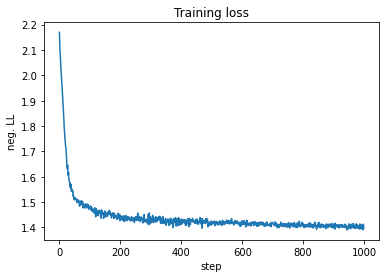

In [10]:
plt.title('Training loss')
plt.plot(loss_stored)
plt.xlabel('step')
plt.ylabel('neg. LL')

In [11]:
# check one prediction
i = 2
_c = data_in_train[i]
_x = samples_train[i]
print(_x)
mixing_p,_s = model.get_grassmann_params(_c.unsqueeze(0))
print("mixing p:",mixing_p)
print("estimated sigmas:",_s)

print("model prob:",model.prob(_x.unsqueeze(0),_c.unsqueeze(0)))

print()

print("fit mean:",model.get_mean(_c.unsqueeze(0)))
print("gt mean:",gt_mean_train[i])

print()

print("fit cov:",model.cov(_c.unsqueeze(0)))
print("gt cov:",gt_cov_train[i])


tensor([0., 1., 0.], dtype=torch.float64)
mixing p: tensor([[0.1094, 0.8906]], grad_fn=<SoftmaxBackward0>)
estimated sigmas: tensor([[[[ 6.8032e-01, -3.2602e-02, -4.1215e-02],
          [-5.1118e-02,  2.3509e-01, -2.1597e-02],
          [-1.6796e-02, -4.8663e-02,  4.2485e-02]],

         [[ 4.5815e-01,  2.5325e-01, -8.1982e-02],
          [ 3.3760e-03,  9.7490e-01,  3.0970e-04],
          [ 3.9388e-01,  8.9219e-02,  9.2971e-02]]]],
       grad_fn=<InverseBackward0>)
model prob: tensor([0.4635], dtype=torch.float64, grad_fn=<SumBackward1>)

fit mean: tensor([[0.4825, 0.8940, 0.0874]], grad_fn=<SumBackward1>)
gt mean: [0.50345186 0.88488172 0.11906055]

fit cov: tensor([[[ 0.2497, -0.0170,  0.0276],
         [-0.0170,  0.0948,  0.0035],
         [ 0.0276,  0.0035,  0.0798]]], grad_fn=<AddBackward0>)
gt cov: tensor([[ 0.2500, -0.0172,  0.0435],
        [-0.0172,  0.1019,  0.0056],
        [ 0.0435,  0.0056,  0.1049]])


In [18]:
# sample from distribution for one specific context
n_samples = 5
model.sample(n_samples,_c.unsqueeze(0))

tensor([[0., 1., 0.],
        [1., 0., 0.],
        [1., 1., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], grad_fn=<IndexBackward0>)

In [21]:
# predict for several contexts
mixing_p, sigma = model.get_grassmann_params(data_in_train[:2])
print(mixing_p)
print(sigma)

tensor([[0.2820, 0.7180],
        [0.5071, 0.4929]], grad_fn=<SoftmaxBackward0>)
tensor([[[[ 0.7465,  0.0714, -0.0167],
          [-0.0322,  0.0868, -0.0166],
          [ 0.0281,  0.0073,  0.0170]],

         [[ 0.9161,  0.1216,  0.0212],
          [-0.0454,  0.9616,  0.0340],
          [ 0.4147,  0.0613,  0.0108]]],


        [[[ 0.0810, -0.0169, -0.0275],
          [-0.0136,  0.0087,  0.0140],
          [ 0.0011, -0.1167,  0.3225]],

         [[ 0.1204,  0.2665, -0.2351],
          [ 0.0106,  0.6180, -0.0232],
          [ 0.0769,  0.0253,  0.8487]]]], grad_fn=<InverseBackward0>)


## Check predictions for means

In [24]:
# predict ALL means
fit_means_test = model.get_mean(data_in_test).detach().numpy()

fit_means_train = model.get_mean(data_in_train).detach().numpy()

Red: train mse 0.00030522359262716926
Blue: test mse 0.0002988089669985175


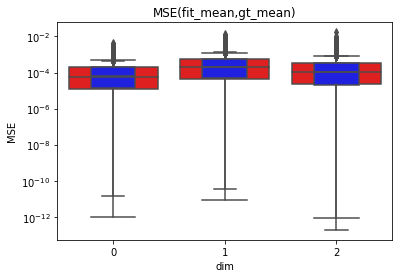

In [25]:
plt.title('MSE(fit_mean,gt_mean)')

ax =sns.boxplot(data=((fit_means_train[:10_000]-gt_mean_train[:10_000])**2),
            color='red',orient='v')
sns.boxplot(data=((fit_means_test-gt_mean_test)**2),
             color='blue',orient='v', width=0.4,ax=ax)
plt.yscale('log')
plt.xlabel('dim')
plt.ylabel('MSE')


print('Red: train mse',np.mean((fit_means_train[:10_000]-gt_mean_train[:10_000])**2))
print('Blue: test mse',np.mean((fit_means_test-gt_mean_test)**2))


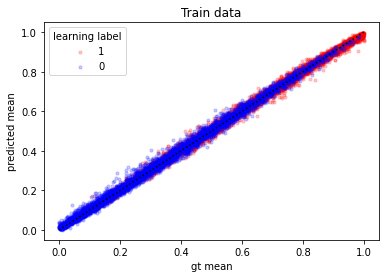

In [26]:
n = 10_000

mask01 = np.array(samples_train.numpy().flatten()[:n],dtype=bool)

plt.title('Train data')


plt.scatter(x = gt_mean_train.flatten()[:n][mask01],
           y = fit_means_train.flatten()[:n][mask01], 
           c='red', 
           alpha=0.2,
           s=10,
           label="1")

plt.scatter(x = gt_mean_train.flatten()[:n][~mask01],
           y = fit_means_train.flatten()[:n][~mask01], 
           c='blue',
           alpha=0.2,
           s=10,
           label="0")

plt.plot([0,1],[0,1], color="black", ls=":")
plt.xlabel("gt mean")
plt.ylabel("predicted mean")

plt.legend(title='learning label')

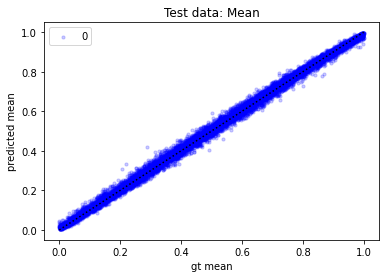

In [27]:
"""
test data
"""
# showing 01 labels makes no sense here!

n = 10_000

mask01 = np.array(samples_test.numpy().flatten()[:n],dtype=bool)

plt.title('Test data: Mean')

plt.scatter(x = gt_mean_test.flatten()[:n],
           y = fit_means_test.flatten()[:n], 
           c='blue',
           alpha=0.2,
           s=10,
           label="0")

plt.plot([0,1],[0,1], color="black", ls=":")
plt.xlabel("gt mean")
plt.ylabel("predicted mean")

plt.legend()

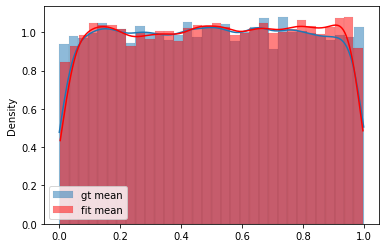

In [28]:
mask01 = np.ones(len(fit_means_test.flatten()),dtype=bool)#np.array(samples_test.numpy().flatten(),dtype=bool)

sns.histplot(gt_mean_test.flatten(),kde=True,lw=0.03, stat="density",label="gt mean")
sns.histplot(fit_means_test.flatten()[mask01],
             kde=True,
             lw=0.03, 
             stat="density", 
             color='red',
            label='fit mean')
sns.histplot(fit_means_test.flatten()[~mask01],kde=True,lw=0.03, stat="density", color='blue')

mask01 = np.array(samples_train.numpy().flatten(),dtype=bool)
#sns.histplot(gt_mean_test.flatten(),kde=True,lw=0.03, stat="density",)
#sns.histplot(fit_means_train.flatten()[mask01][:10_000],kde=True,lw=0.03, stat="density", color='orange')
#sns.histplot(fit_means_train.flatten()[~mask01][:10_000],kde=True,lw=0.03, stat="density", color='darkblue')

#sns.displot(fit_means.flatten()[mask01])
plt.legend()

### look into cov

In [29]:
# predict ALL covs
fit_cov_test = model.cov(data_in_test)
fit_cov_test = fit_cov_test.squeeze().detach().numpy()


fit_cov_train = model.cov(data_in_train)
fit_cov_train = fit_cov_train.squeeze().detach().numpy()


In [30]:
# extract upper diag and flatten
dim = 3
tril_inds = np.tril_indices(dim, -1)


# all
gt_cov_test_flatten = np.array(gt_cov_test)[:,tril_inds[0],tril_inds[1]].flatten()
fit_cov_test_flatten = np.array(fit_cov_test)[:,tril_inds[0],tril_inds[1]].flatten()

gt_cov_train_flatten = np.array(gt_cov_train)[:,tril_inds[0],tril_inds[1]].flatten()
fit_cov_train_flatten = np.array(fit_cov_train)[:,tril_inds[0],tril_inds[1]].flatten()


# only for specific dims
gt_cov_test_flatten12 = np.array(gt_cov_test)[:,1,2].flatten()
fit_cov_test_flatten12 = np.array(fit_cov_test)[:,1,2].flatten()
gt_cov_train_flatten12 = np.array(gt_cov_train)[:,1,2].flatten()
fit_cov_train_flatten12 = np.array(fit_cov_train)[:,1,2].flatten()


gt_cov_test_flatten01 = np.array(gt_cov_test)[:,0,1].flatten()
fit_cov_test_flatten01 = np.array(fit_cov_test)[:,0,1].flatten()
gt_cov_train_flatten01 = np.array(gt_cov_train)[:,0,1].flatten()
fit_cov_train_flatten01 = np.array(fit_cov_train)[:,0,1].flatten()

gt_cov_test_flatten02 = np.array(gt_cov_test)[:,0,2].flatten()
fit_cov_test_flatten02 = np.array(fit_cov_test)[:,0,2].flatten()
gt_cov_train_flatten02 = np.array(gt_cov_train)[:,0,2].flatten()
fit_cov_train_flatten02 = np.array(fit_cov_train)[:,0,2].flatten()

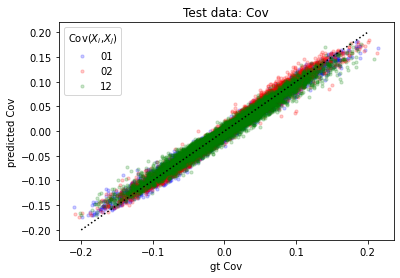

In [31]:
"""
test data Cov
"""

n = 10_000

plt.title('Test data: Cov')

plt.scatter(x = gt_cov_test_flatten01,
           y = fit_cov_test_flatten01, 
           c='blue',
           alpha=0.2,
           s=10,
           label="01")

plt.scatter(x = gt_cov_test_flatten02,
           y = fit_cov_test_flatten02, 
           c='red',
           alpha=0.2,
           s=10,
           label="02")

plt.scatter(x = gt_cov_test_flatten12,
           y = fit_cov_test_flatten12, 
           c='green',
           alpha=0.2,
           s=10,
           label="12")

plt.plot([-0.2,0.2],[-0.2,0.2], color="black", ls=":")
plt.xlabel("gt Cov")
plt.ylabel("predicted Cov")

plt.legend(title='Cov($X_i$,$X_j$)')

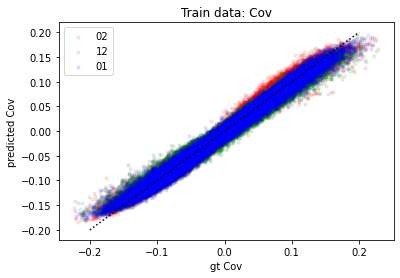

In [32]:
"""
Train data Corr
"""

n = 100_000

plt.title('Train data: Cov')


plt.scatter(x = gt_cov_train_flatten02[:n],
           y = fit_cov_train_flatten02[:n], 
           c='red',
           alpha=0.1,
           s=10,
           label="02")

plt.scatter(x = gt_cov_train_flatten12[:n],
           y = fit_cov_train_flatten12[:n], 
           c='green',
           alpha=0.1,
           s=10,
           label="12")


plt.scatter(x = gt_cov_train_flatten01[:n],
           y = fit_cov_train_flatten01[:n], 
           c='blue',
           alpha=0.1,
           s=10,
           label="01")

plt.plot([-0.2,0.2],[-0.2,0.2], color="black", ls=":")
plt.xlabel("gt Cov")
plt.ylabel("predicted Cov")

plt.legend()

In [33]:
np.std(gt_cov_train_flatten)

0.051490944

In [34]:
np.std(fit_cov_train_flatten01)

0.049996812

In [35]:
np.mean((fit_cov_test_flatten-gt_cov_test_flatten)**2) *100_000

6.466175545938313

In [36]:
np.mean((fit_cov_train_flatten[:100_000]-gt_cov_train_flatten[:100_000])**2)*100_000

6.386340828612447

/home/cornelius/anaconda3/envs/base_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/cornelius/anaconda3/envs/base_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


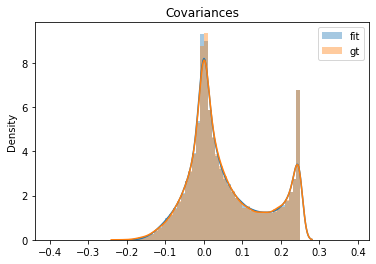

In [37]:
plt.title("Covariances")
sns.distplot(fit_cov_test.flatten(), bins=np.arange(-.4,.4,0.01), label="fit")
sns.distplot(gt_cov_test.flatten(), bins=np.arange(-.4,.4,0.01), label="gt")
plt.legend()